# Examples and test results:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import warnings
warnings.filterwarnings('ignore')
simltr = QuantumInstance(Aer.get_backend("statevector_simulator"))

In [2]:
total_num_layers = 4 # max number of layers to be applied
num_params = 16 #number of parameters per layer
out_states = ["0011", "0101", "1010", "1100"]

## Building our circuit which will be reused frequently:

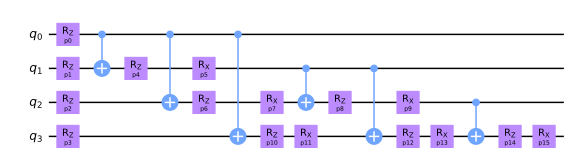

In [3]:
layer = QuantumCircuit(4, name = "layer")
vqc_params = []

for i in range(4):
    param = Parameter('p{}'.format(i))
    vqc_params.append(param)
    layer.rz(param, i)
p=4
for i in range(1,4):
    for j in range(i):
        layer.cx(j,i)
        param = Parameter('p{}'.format(p))
        vqc_params.append(param)
        layer.rz(param, i)
        p+=1
        param = Parameter('p{}'.format(p))
        vqc_params.append(param)
        layer.rx(param, i)
        p+=1
# next we display the circuit named "layer" made here:
layer.draw(output='mpl',scale=0.75)

In [4]:
vqc = QuantumCircuit(4)
num_layers = 0 # keep a count of the number of layers being applied
vqc.h(range(4))
#Assign new parameters
for i in range(total_num_layers): 
    params = {} 
    for t in range(num_params):
        param = Parameter('p{}'.format(t + num_layers*num_params))
        params[vqc_params[t]] = param
    _layer = layer.assign_parameters(params, inplace = False) #Assign new paramger
    _layer.name = 'layer{}'.format(i)
    vqc.append(_layer, range(4))
    vqc.barrier()
    vqc.h(range(4))
    num_layers += 1
# now we show the number of params, layers and the variational quantum circuit we are going to use for the task:
print(f"Number of variational parameters assigned per layer = {num_params}",end='\n')
print(f"Number of layers used = {num_layers}",end='\n')
# display(vqc.decompose().draw(output='mpl',scale=0.6))

Number of variational parameters assigned per layer = 16
Number of layers used = 4


### Input states : [`"0011"`, `"0110"`, `"1001"`, `"1010"`]

the mapping should look like:
0011  ->  0011
0110  ->  0101
1001  ->  1010
1010  ->  1100


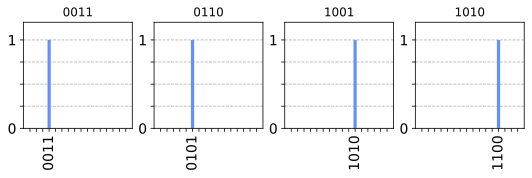

In [5]:
in_states = ["0011", "0110", "1001", "1010"]
final_params = [ 1.57078548e+00, -2.39238098e-05, -1.57079102e+00,  1.57080765e+00,
  1.57081510e+00, -1.26715679e-05,  1.57079873e+00,  7.41055506e-01,
  1.57078608e+00, -7.85410232e-01,  3.92499730e-06,  8.29710419e-01,
  1.57085302e+00,  3.50577285e-05,  2.38640151e+00,  3.14155152e+00,
 -1.89976404e+00,  3.14162357e+00, -3.20053071e+00,  1.57080699e+00,
 -7.54643438e-01,  1.57081722e+00,  1.68730888e-01, -1.57077540e+00,
  1.45431033e-05,  6.65876873e-01,  7.55203428e-01,  2.20529933e-05,
 -1.19526219e-05,  7.36192954e-01,  2.35615685e+00,  1.57074493e+00,
  1.57079473e+00, -1.57765051e+00, -1.57085370e+00, -5.99117587e-05,
  3.14845554e+00, -2.29293473e-05,  1.57078950e+00,  1.57079595e+00,
  3.39357961e+00,  4.09832026e-05, -1.06260237e+00,  2.35617808e+00,
  3.09999749e+00, -3.18238416e-05,  2.57052356e-05, -8.01760286e-01,
 -7.94889350e-01, -1.57080347e+00,  1.57077445e+00,  1.40045206e+00,
  3.14154395e+00,  2.70519595e-01, -7.94846043e-01, -1.44155428e-05,
 -3.17831641e-06,  1.57080548e+00,  2.42643571e-01, -1.79843675e-05,
  8.76550934e-01, -3.81168602e-05,  2.08612924e+00,  3.59271386e-06]
final_cost = -0.3999998696601804
nfev = 3319

states = []
for item in in_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #Note: adjusted for the little-endianness of qiskit
        if item[i] == "1": 
            state.x(3-i)
    states.append(state)
mapping = dict(zip(in_states,out_states))
print("the mapping should look like:")
for k,v in mapping.items():
    print(k,' -> ',v)
    
fig = plt.figure(figsize=(9, 9))
for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(in_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
# plt.show()
plt.savefig("3,6,9,10_4layer.png")

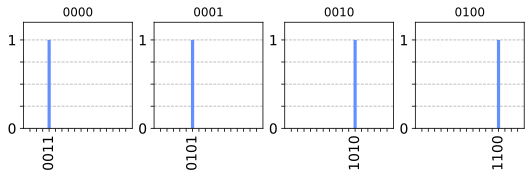

In [6]:
#generating the other possible input states
rem_states = [f'{i:4b}'.replace(' ','0') for i in range(16)]
for i,elem in enumerate(in_states):
    rem_states.remove(elem)
for item in rem_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #adjusting for the endian-ness of qiskit
        if item[i] == "1": 
            state.x(3-i)
    states.append(state)
#to check the outputs for the remaining states that can be used as input to the VQC
fig = plt.figure(figsize=(9, 9))
for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

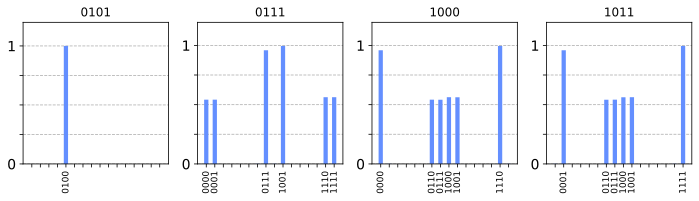

In [7]:
fig = plt.figure(figsize=(12, 12))
for i in range(4,8):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,figsize=(5, 5),bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90,fontsize=9)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

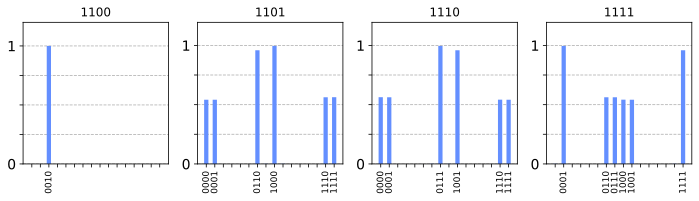

In [8]:
fig = plt.figure(figsize=(12, 12))
for i in range(8,12):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,figsize=(5, 5),bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90,fontsize=9)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

-----------------------------------------------------------------------------------

### Input states : [`"1010"`, `"1011"`, `"1100"`, `"1101"`]

the mapping should look like:
1010  ->  0011
1011  ->  0101
1100  ->  1010
1101  ->  1100


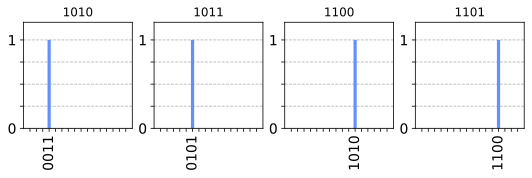

In [9]:
in_states = ["1010", "1011", "1100", "1101"]
final_params = [-4.36926947e-05,  1.57079481e+00, -4.36160985e-06, -1.12844457e+00,
  1.57071452e+00,  8.78689498e-01,  1.75902584e-05,  5.76021224e-01,
  1.57078964e+00, -1.57083447e+00, -1.77898643e-05,  1.16171348e-01,
 -1.90592648e-06, -2.43647946e+00,  1.38247087e+00, -7.24146432e-07,
  2.38683850e-01, -1.59565287e-05,  7.09829714e-01, -1.63033799e-05,
  7.02951332e-03, -1.35754604e-05, -1.67458560e-01,  2.14797988e-05,
  9.47580565e-01, -1.43195344e-02, -4.83125111e-02, -1.93340275e-01,
  2.45583452e+00,  6.89433287e-02,  9.30454361e-01,  3.41067742e-05,
  1.09072631e-01, -3.76146883e-04,  6.16844534e-01,  1.84724641e-01,
  3.65896811e-04,  2.80405145e+00,  1.35946688e-04,  1.07561555e+00,
 -1.55832296e-05,  1.48590846e+00, -1.37541540e-01,  1.23572708e-04,
  1.83838248e-05,  1.57075926e+00,  1.46099528e-05,  1.37558756e-01,
 -6.89160154e-06,  2.21114303e+00, -5.27824591e-05,  1.38105168e+00,
  1.18649524e+00, -7.98060249e-01, -6.99679478e-06,  1.66350753e+00,
  9.64326582e-06, -2.88660418e-06,  1.54473402e+00,  2.92234572e-06,
  7.54310766e-01,  2.07529098e+00,  7.57084275e-01,  1.01594276e+00]
final_cost = -0.3999998310995252
nfev = 6278

states = []
for item in in_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #Note: adjusted for the little-endianness of qiskit
        if item[i] == "1": 
            state.x(3-i)
    states.append(state)
mapping = dict(zip(in_states,out_states))
print("the mapping should look like:")
for k,v in mapping.items():
    print(k,' -> ',v)
    
fig = plt.figure(figsize=(9, 9))
for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(in_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
# plt.show()
plt.savefig("10,11,12,13_4layer.png")

### Outputs for the remaining states

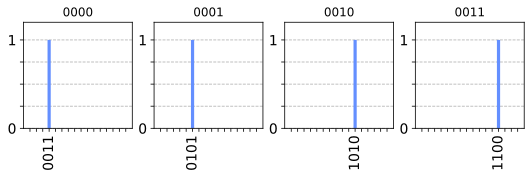

In [10]:
#generating the other possible input states
rem_states = [f'{i:4b}'.replace(' ','0') for i in range(16)]
for i,elem in enumerate(in_states):
    rem_states.remove(elem)
for item in rem_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #adjusting for the endian-ness of qiskit
        if item[i] == "1": 
            state.x(3-i)
    states.append(state)
#to check the outputs for the remaining states that can be used as input to the VQC
fig = plt.figure(figsize=(9, 9))
for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

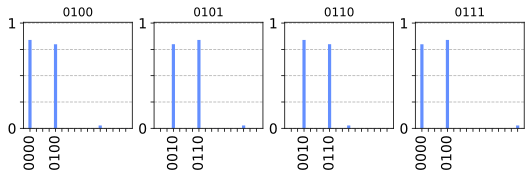

In [11]:
fig = plt.figure(figsize=(9, 9))
for i in range(4,8):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

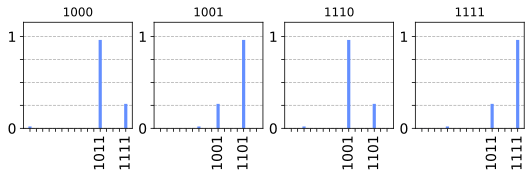

In [12]:
fig = plt.figure(figsize=(9, 9))
for i in range(8,12):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

------------------------------------------------------------------------------------------

### Input states : [`"0000"`, `"0100"`, `"1000"`,`"1100"`]

the mapping should look like:
0000  ->  0011
0100  ->  0101
1000  ->  1010
1100  ->  1100


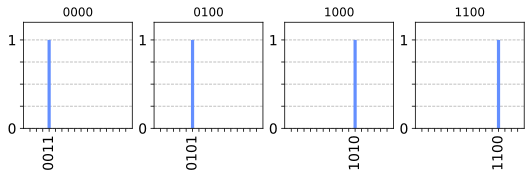

In [13]:
in_states = ["0000", "0100", "1000", "1100"]
final_params = [ 1.99539419e+00,  1.57079364e+00,  1.57079093e+00,  3.25667056e-06,
 -1.03254632e+00,  1.57079907e+00,  1.57078657e+00,  6.52968875e-01,
  8.07755097e-01,  6.99967997e-01, -3.20044394e-06,  9.17815395e-01,
  1.57078919e+00,  1.98724321e-01,  8.19184220e-06,  2.21824774e-06,
  8.79125420e-01,  2.97693979e-05,  8.03163277e-01,  7.58712767e-01,
  2.10445468e-05,  8.37744632e-01,  1.57077944e+00,  1.57075337e+00,
  1.84954242e+00, -8.73690689e-02,  1.34898462e-05, -1.89781529e-05,
  1.57079568e+00,  8.74279621e-02,  1.57076403e+00,  1.57083138e+00,
  5.09829400e-05, -9.94186986e-01,  1.57078875e+00,  1.40564892e-05,
 -5.76600943e-01,  2.44186867e-05,  1.33101644e+00,  5.48544734e-05,
  1.96652857e-01,  1.77797471e+00,  5.38154026e-01,  3.39518562e-01,
  1.57080125e+00,  1.99537581e+00,  7.63048198e-01,  3.24202835e-01,
  1.57075210e+00,  1.57734999e+00,  8.70829904e-01, -3.86028418e-01,
 -1.23345043e-05,  2.47931855e+00,  7.83513228e-01, -5.68242929e-02,
 -1.32809203e-06, -3.02682809e-05,  4.91359047e-01, -2.52455126e-05,
  7.97100390e-02,  1.54650636e+00, -1.67964252e+00, -2.20046732e-01]
final_cost = -0.39999996744002003 
nfev = 4179

states = []
for item in in_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #Note: adjusted for the little-endianness of qiskit
        if item[i] == "1": 
            state.x(3-i)
    states.append(state)
mapping = dict(zip(in_states,out_states))
print("the mapping should look like:")
for k,v in mapping.items():
    print(k,' -> ',v)
    
fig = plt.figure(figsize=(9, 9))
for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(in_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
# plt.show()
plt.savefig("0,4,8,12_4layer.png")

### Outputs for the remaining states

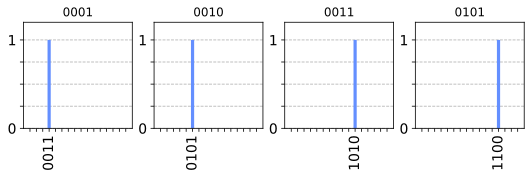

In [14]:
#generating the other possible input states
rem_states = [f'{i:4b}'.replace(' ','0') for i in range(16)]
for i,elem in enumerate(in_states):
    rem_states.remove(elem)
for item in rem_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #adjusting for the endian-ness of qiskit
        if item[i] == "1": 
            state.x(3-i)
    states.append(state)
#to check the outputs for the remaining states that can be used as input to the VQC
fig = plt.figure(figsize=(9, 9))
for i in range(4):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

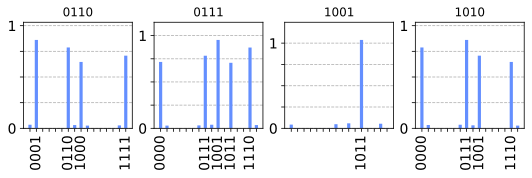

In [15]:
fig = plt.figure(figsize=(9, 9))
for i in range(4,8):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()

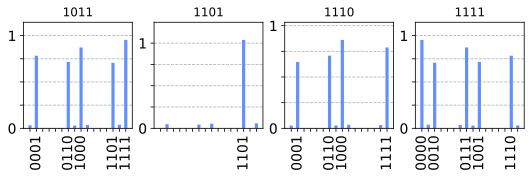

In [16]:
fig = plt.figure(figsize=(9, 9))
for i in range(8,12):
    ax = fig.add_subplot(4,4,i+1)
    data = (Statevector(simltr.execute(states[i].compose(vqc.assign_parameters(final_params, inplace = False))).get_statevector()).probabilities_dict())
    plot_histogram(data,bar_labels=False,title="{}".format(rem_states[i]),ax=ax)
    val = list(data.values())
    lab = list(data.keys())
    ax.set_xticklabels([lab[i] if val[i] > 0.09 else ' ' for i in range(len(val))],rotation=90)
    ax.set_yticklabels(['0',' ',' ',' ','1'])
    ax.set_ylabel("")
plt.show()